In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-exchange-data/indexProcessed.csv
/kaggle/input/stock-exchange-data/indexData.csv
/kaggle/input/stock-exchange-data/indexInfo.csv


In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM, Dense
from keras.models import Sequential

In [3]:
df = pd.read_csv('/kaggle/input/stock-exchange-data/indexProcessed.csv')

In [4]:
df

,Index,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,HSI,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,HSI,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,HSI,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,HSI,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,HSI,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013
...,...,...,...,...,...,...,...,...,...
104219,J203.JO,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578
104220,J203.JO,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859
104221,J203.JO,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500
104222,J203.JO,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104224 entries, 0 to 104223
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Index      104224 non-null  object 
 1   Date       104224 non-null  object 
 2   Open       104224 non-null  float64
 3   High       104224 non-null  float64
 4   Low        104224 non-null  float64
 5   Close      104224 non-null  float64
 6   Adj Close  104224 non-null  float64
 7   Volume     104224 non-null  float64
 8   CloseUSD   104224 non-null  float64
dtypes: float64(7), object(2)
memory usage: 7.2+ MB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,CloseUSD
count,104224.000000,104224.000000,104224.000000,104224.000000,104224.000000,1.042240e+05,104224.000000
mean,8015.353334,8063.324234,7962.581120,8014.366642,8014.161269,1.347646e+09,3046.729177
std,9140.563404,9196.575802,9082.767802,9140.609758,9140.720456,4.427662e+09,3747.865623
min,54.869999,54.869999,54.869999,54.869999,54.869999,0.000000e+00,10.204900
25%,2046.887756,2057.213990,2037.185943,2047.506470,2047.358490,0.000000e+00,320.460898
50%,5772.140137,5812.764892,5725.199951,5773.710205,5773.710205,9.529000e+05,1371.598486
75%,10487.377445,10552.179690,10416.092287,10488.622560,10488.622560,2.064676e+08,4383.045241
max,68775.062500,69403.750000,68516.992190,68775.062500,68775.062500,9.440374e+10,18934.376173


In [7]:
df.isna().sum()

Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
CloseUSD     0
dtype: int64

In [8]:
df['Index'].unique()

array(['HSI', 'NYA', 'IXIC', '000001.SS', 'N225', 'N100', '399001.SZ',
       'GSPTSE', 'NSEI', 'GDAXI', 'SSMI', 'TWII', 'J203.JO'], dtype=object)

In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0        1986-12-31
1        1987-01-02
2        1987-01-05
3        1987-01-06
4        1987-01-07
            ...    
104219   2021-05-25
104220   2021-05-26
104221   2021-05-27
104222   2021-05-28
104223   2021-05-31
Name: Date, Length: 104224, dtype: datetime64[ns]

In [10]:
df_sort=df.sort_values(['Index','Date']).set_index('Date')
df_sort

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
1997-07-02,000001.SS,1255.909058,1261.571045,1147.331055,1199.061035,1199.061035,0.0,191.849766
1997-07-03,000001.SS,1194.676025,1194.676025,1149.939941,1150.623047,1150.623047,0.0,184.099688
1997-07-04,000001.SS,1138.921021,1163.249023,1124.776001,1159.342041,1159.342041,0.0,185.494727
1997-07-07,000001.SS,1161.707031,1163.447021,1085.572021,1096.818970,1096.818970,0.0,175.491035
1997-07-08,000001.SS,1092.798950,1115.432983,1066.043945,1109.666016,1109.666016,0.0,177.546563
...,...,...,...,...,...,...,...,...
2021-05-25,TWII,16444.750000,16657.599610,16444.750000,16595.669920,16595.669920,9038500.0,663.826797
2021-05-26,TWII,16645.169920,16706.289060,16523.230470,16643.689450,16643.689450,6816100.0,665.747578
2021-05-27,TWII,16591.699220,16601.609380,16419.419920,16601.609380,16601.609380,8532000.0,664.064375


In [11]:
plt.rcParams['figure.figsize']=(15,5)
plt.style.use('ggplot')

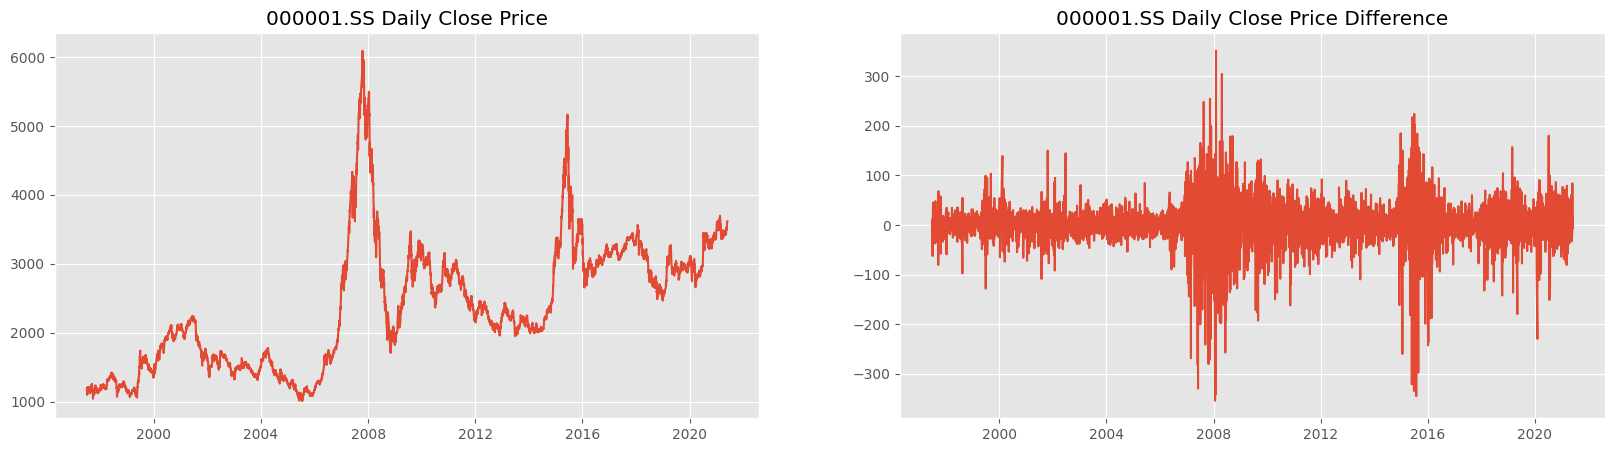

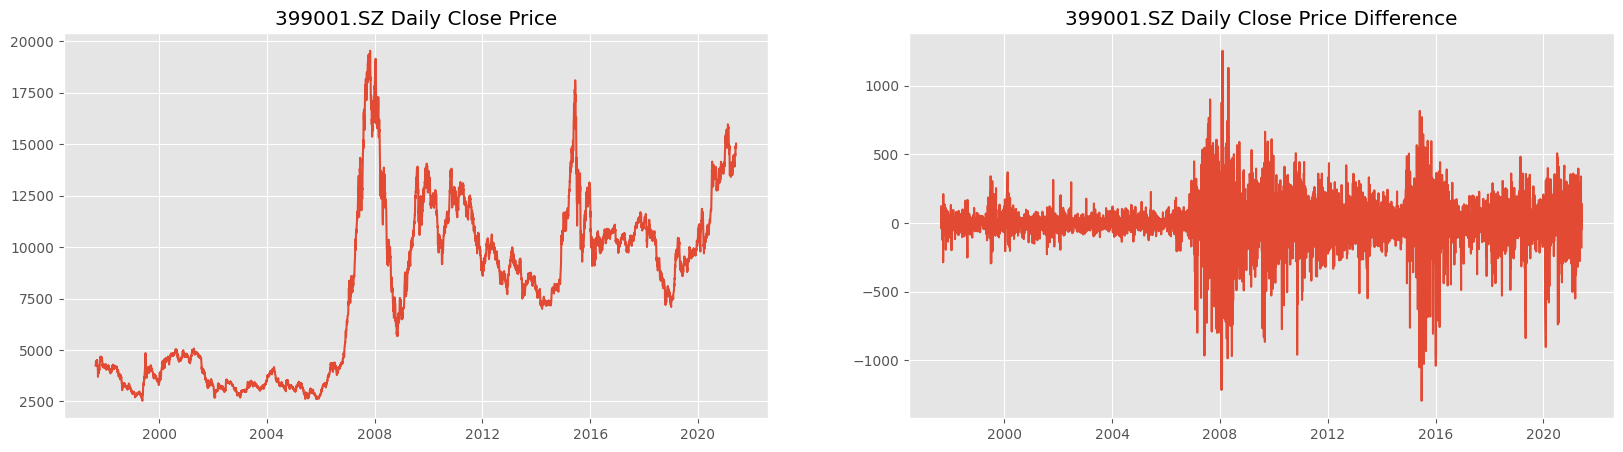

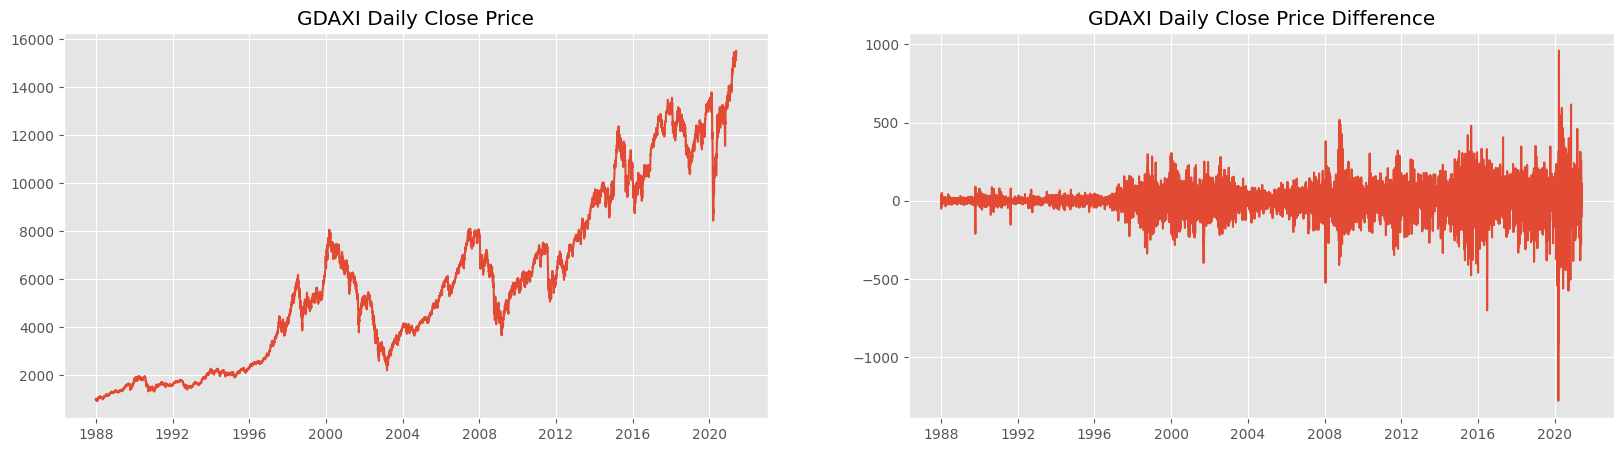

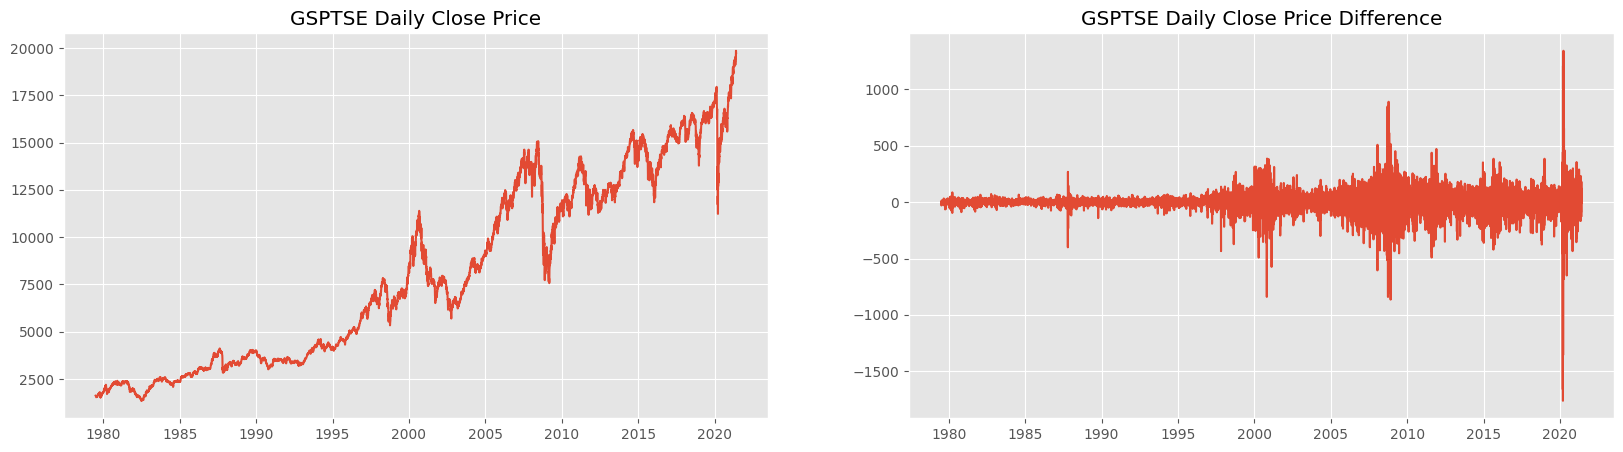

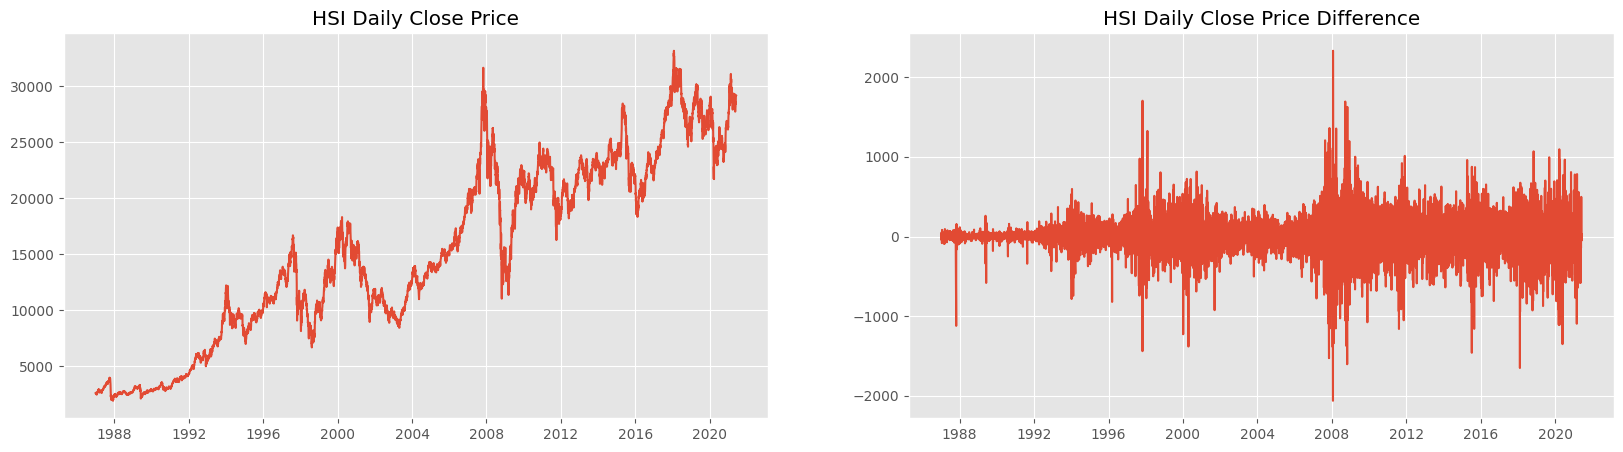

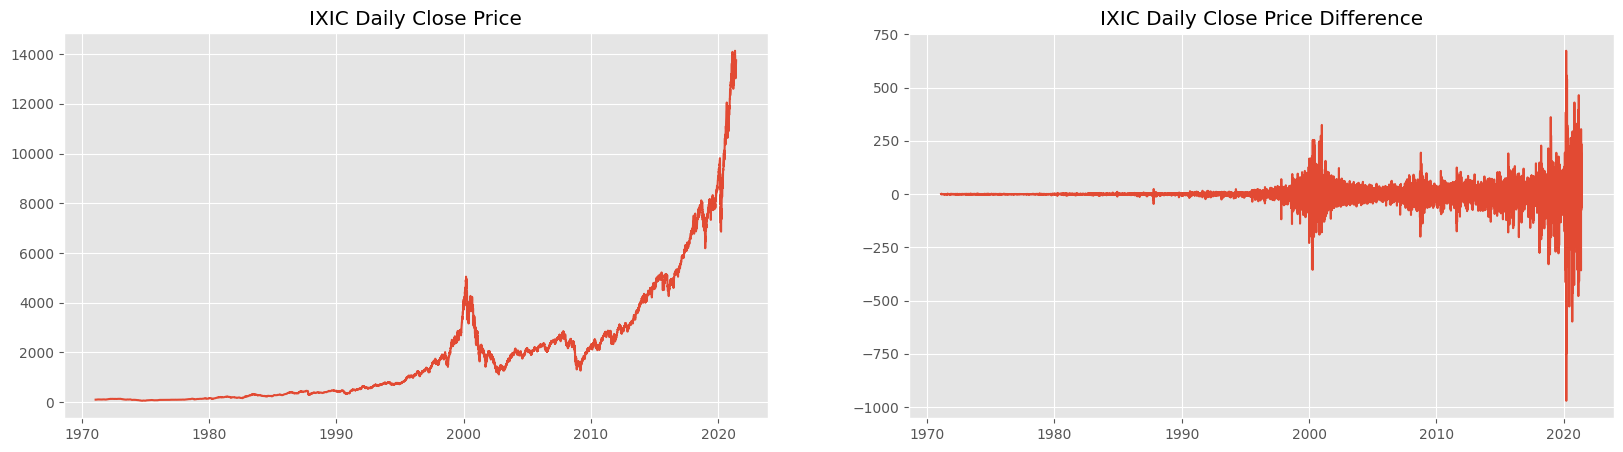

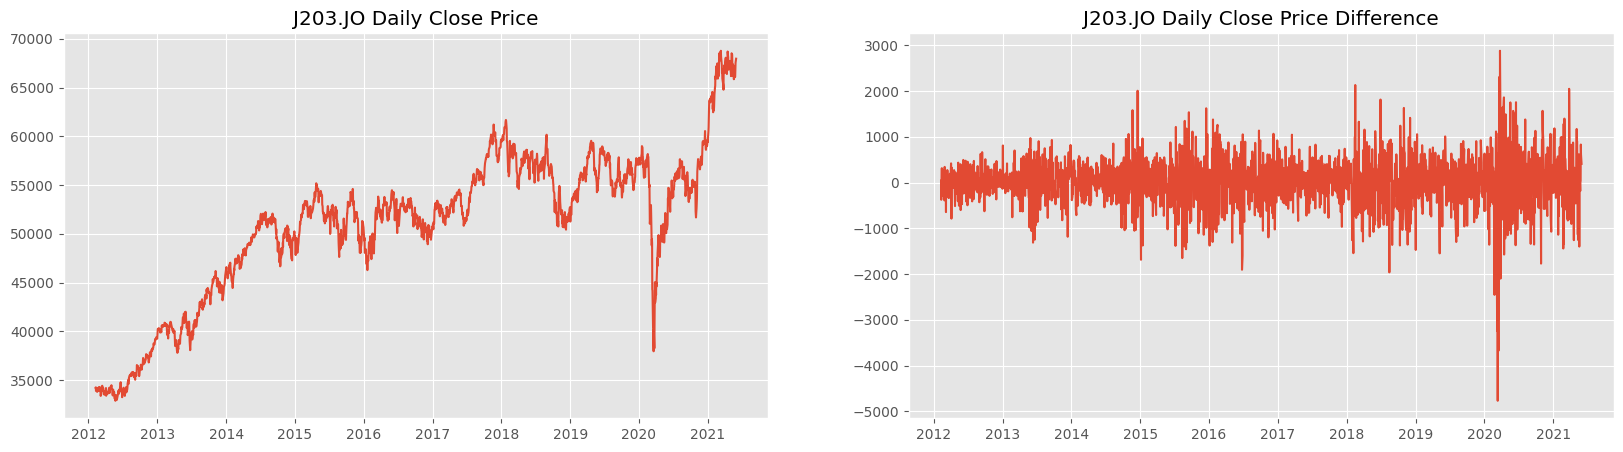

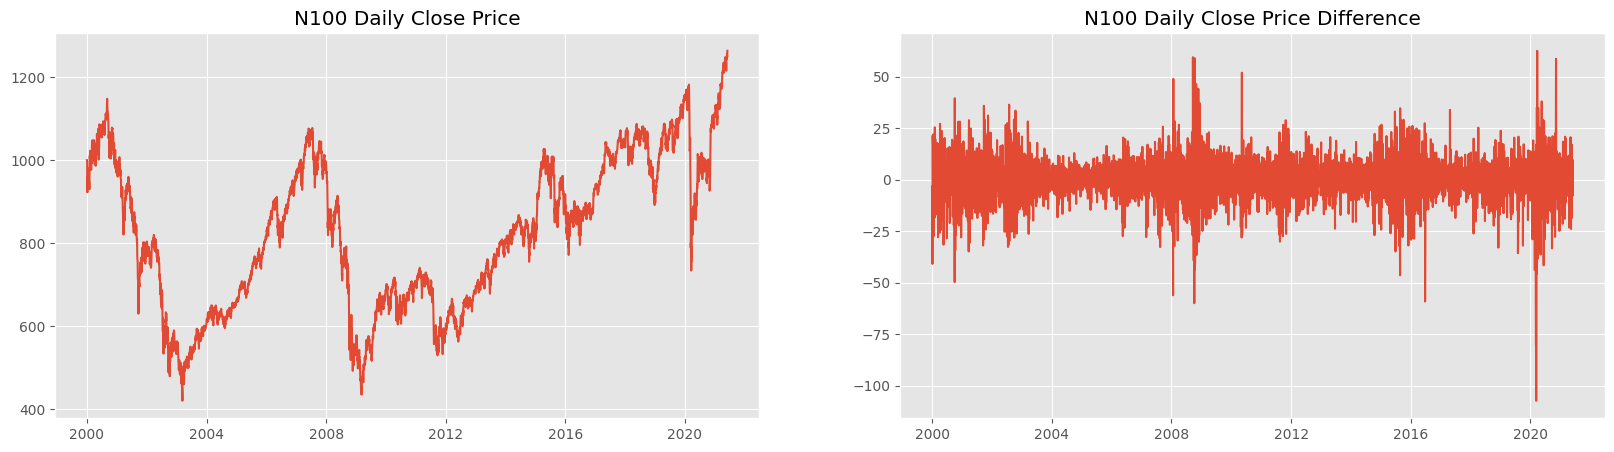

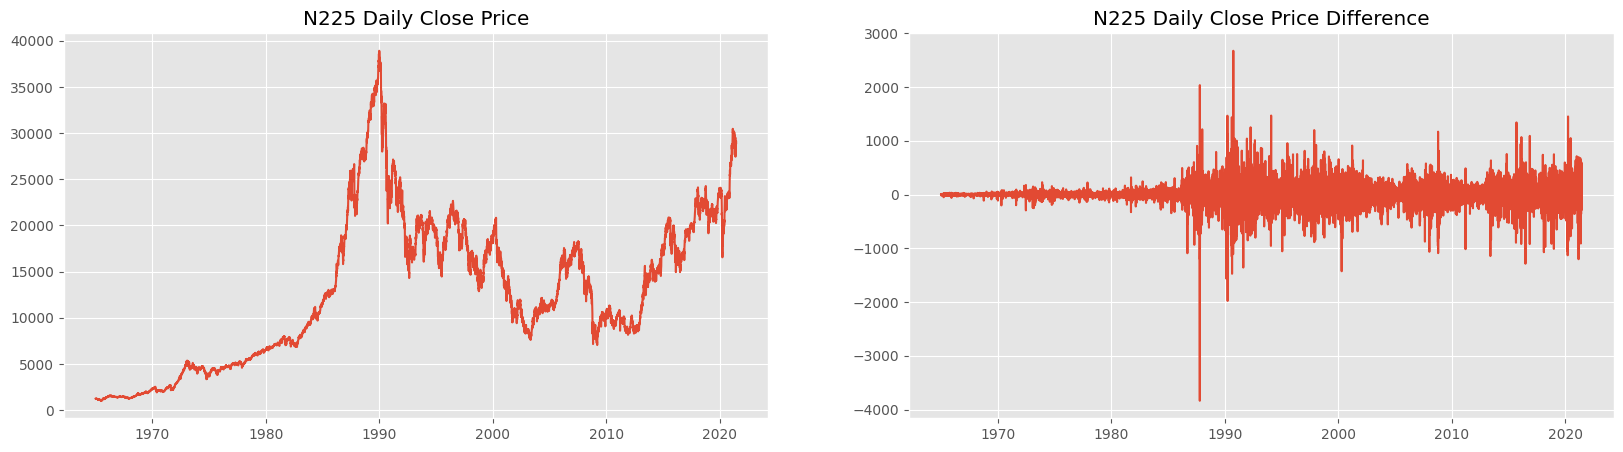

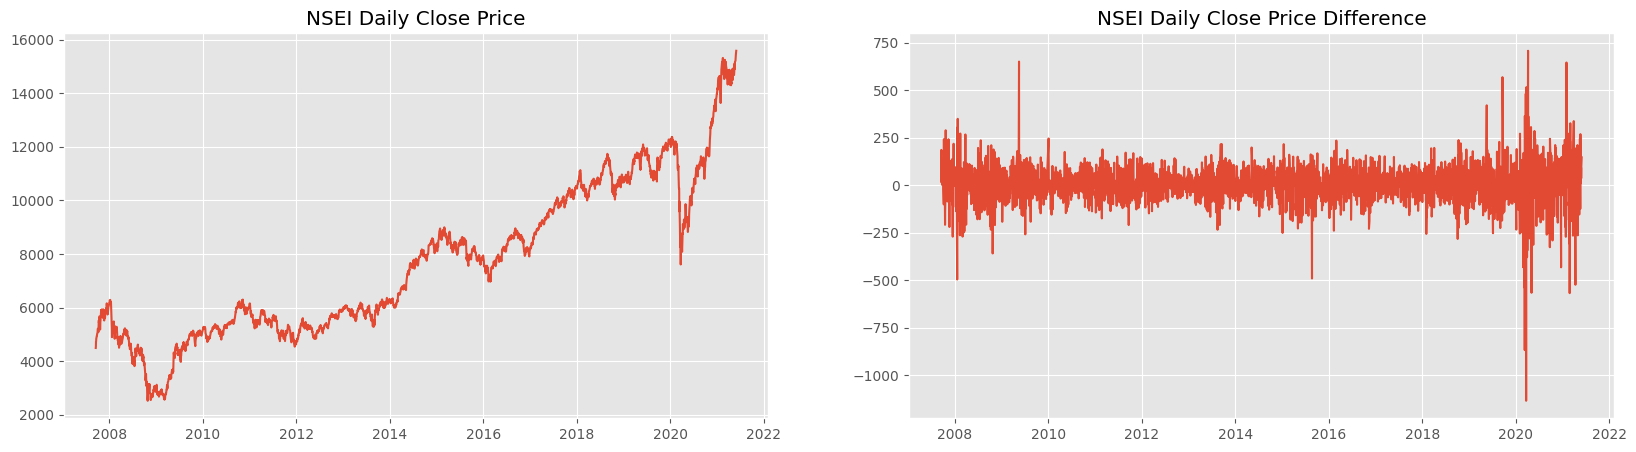

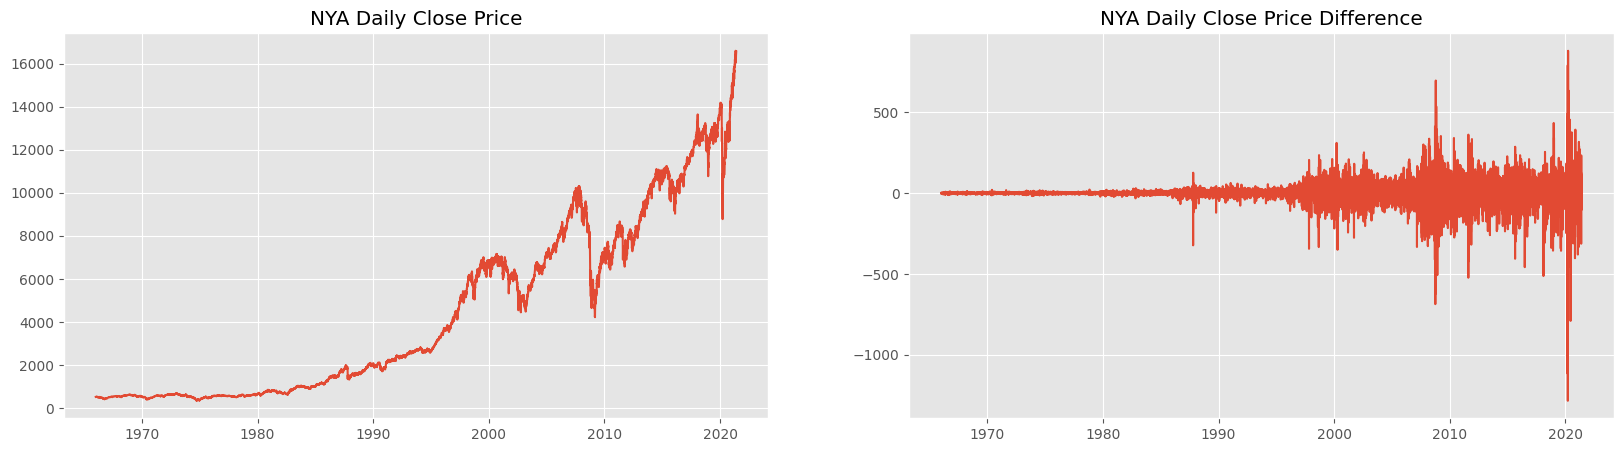

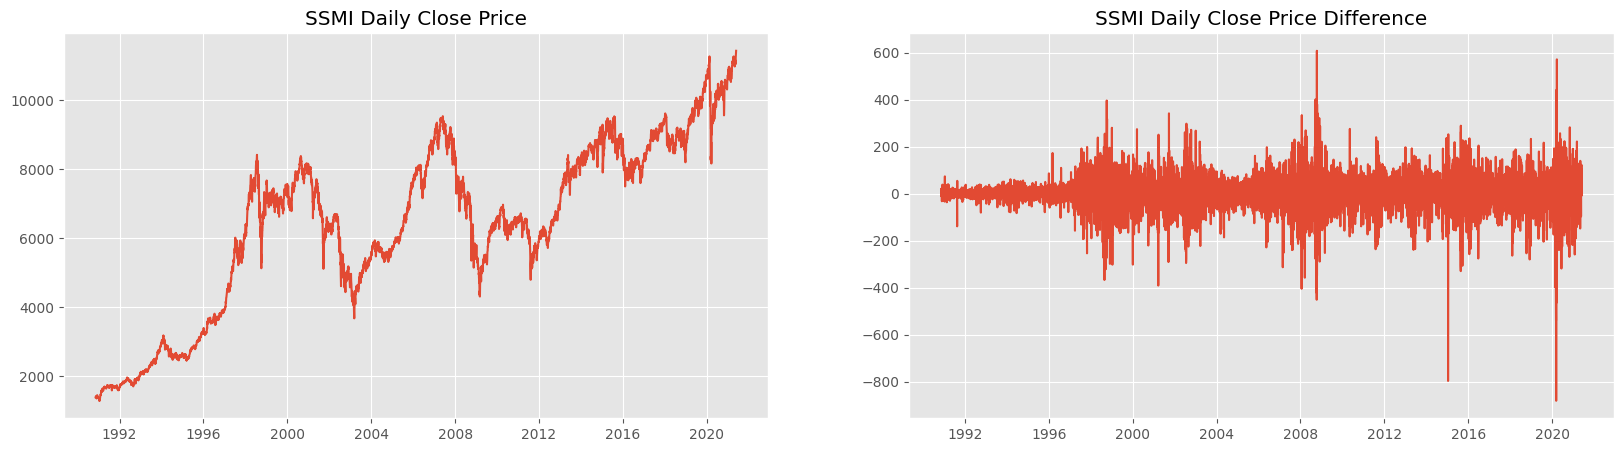

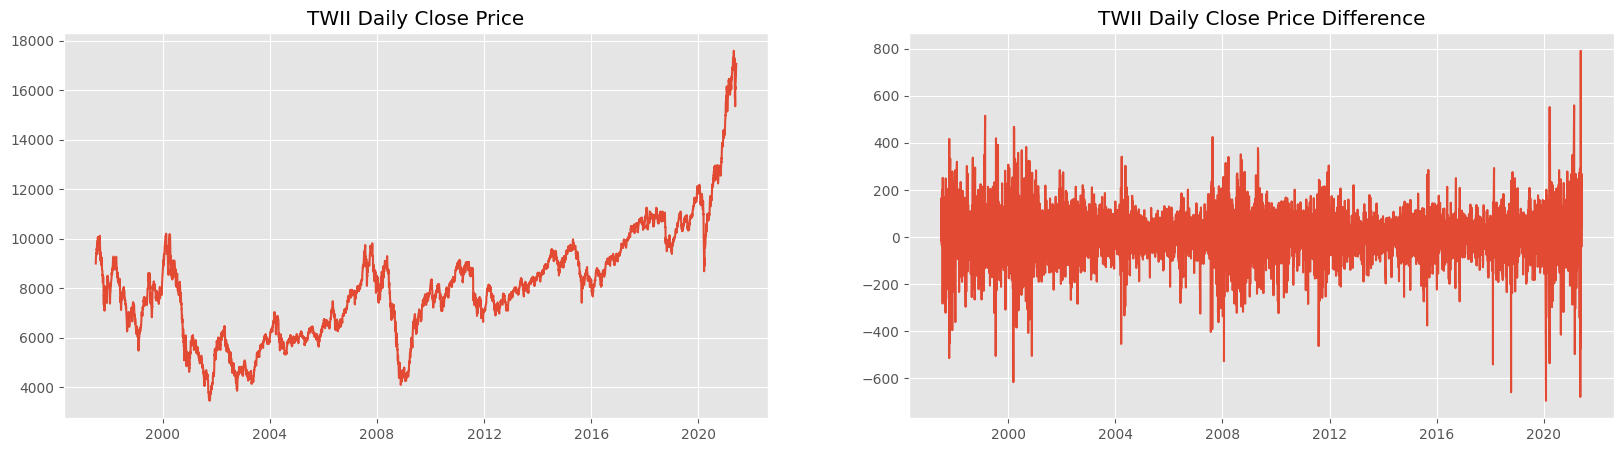

In [12]:
for i in df_sort['Index'].unique():
    fig, axs= plt.subplots(nrows=1 , ncols=2, figsize=(20,5))
    axs[0].plot(df_sort[df_sort['Index'] == i]['Close'])

    axs[1].plot(df_sort[df_sort['Index'] == i]['Close'].diff())
    
    axs[0].set_title(f'{i} Daily Close Price')
    axs[1].set_title(f'{i} Daily Close Price Difference')
    
    plt.show()

In [13]:
nya = df_sort[df_sort['Index'] == 'NYA']
nya

,Index,Open,High,Low,Close,Adj Close,Volume,CloseUSD
Date,,,,,,,,
1965-12-31,NYA,528.690002,528.690002,528.690002,528.690002,528.690002,0.000000e+00,528.690002
1966-01-03,NYA,527.210022,527.210022,527.210022,527.210022,527.210022,0.000000e+00,527.210022
1966-01-04,NYA,527.840027,527.840027,527.840027,527.840027,527.840027,0.000000e+00,527.840027
1966-01-05,NYA,531.119995,531.119995,531.119995,531.119995,531.119995,0.000000e+00,531.119995
1966-01-06,NYA,532.070007,532.070007,532.070007,532.070007,532.070007,0.000000e+00,532.070007
...,...,...,...,...,...,...,...,...
2021-05-24,NYA,16375.000000,16508.519530,16375.000000,16464.689450,16464.689450,2.947400e+09,16464.689450
2021-05-25,NYA,16464.689450,16525.810550,16375.150390,16390.189450,16390.189450,3.420870e+09,16390.189450
2021-05-26,NYA,16390.189450,16466.339840,16388.320310,16451.960940,16451.960940,3.674490e+09,16451.960940


In [14]:
nya['Open_Close'] = nya['Close'].values - nya['Open'].values

/tmp/ipykernel_1156/2002961877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nya['Open_Close'] = nya['Close'].values - nya['Open'].values


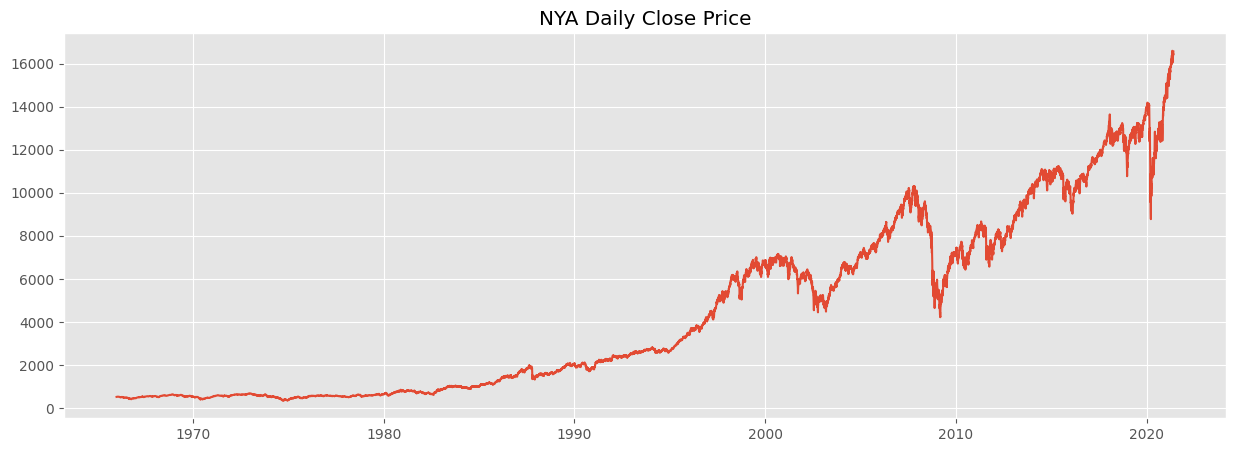

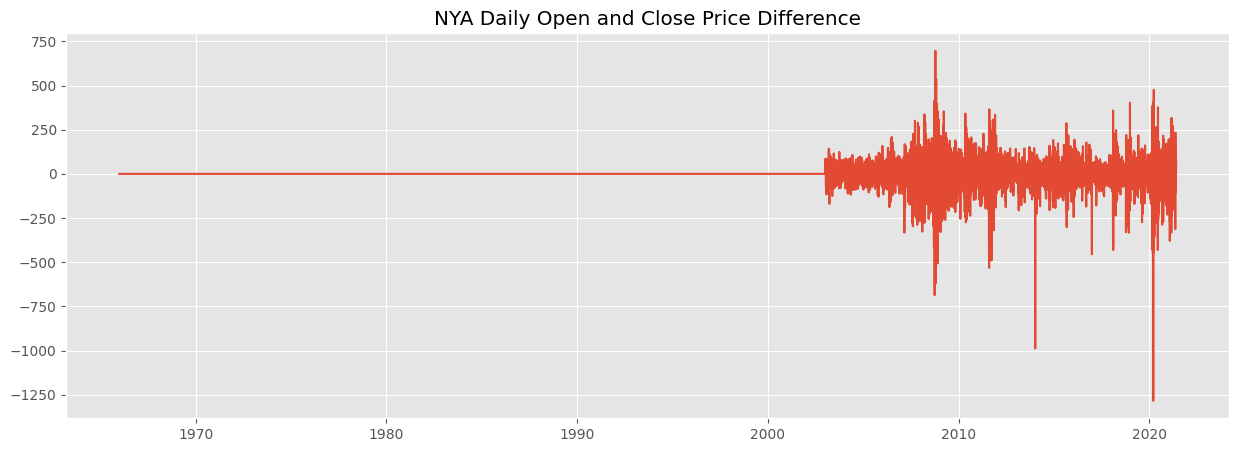

In [15]:
plt.plot(nya['Close'])
plt.title('NYA Daily Close Price')
plt.show()

plt.plot(nya['Open_Close'])
plt.title('NYA Daily Open and Close Price Difference')
plt.show()

All time highest close price

In [16]:
nya.sort_values('Close' , ascending=False)[['Close']][:3]

,Close
Date,
2021-05-07,16590.42969
2021-05-28,16555.66016
2021-05-27,16531.94922


All time lowest close price

In [17]:
nya.sort_values('Close' , ascending=True)[['Close']][:3]

,Close
Date,
1974-10-03,347.769989
1974-10-04,347.880005
1974-10-01,353.059998


In [18]:
nya.sort_values('Open_Close' , ascending=True)[['Open_Close']][:3]

,Open_Close
Date,
2020-03-16,-1284.450197
2014-01-07,-988.040040
2008-09-29,-686.360351


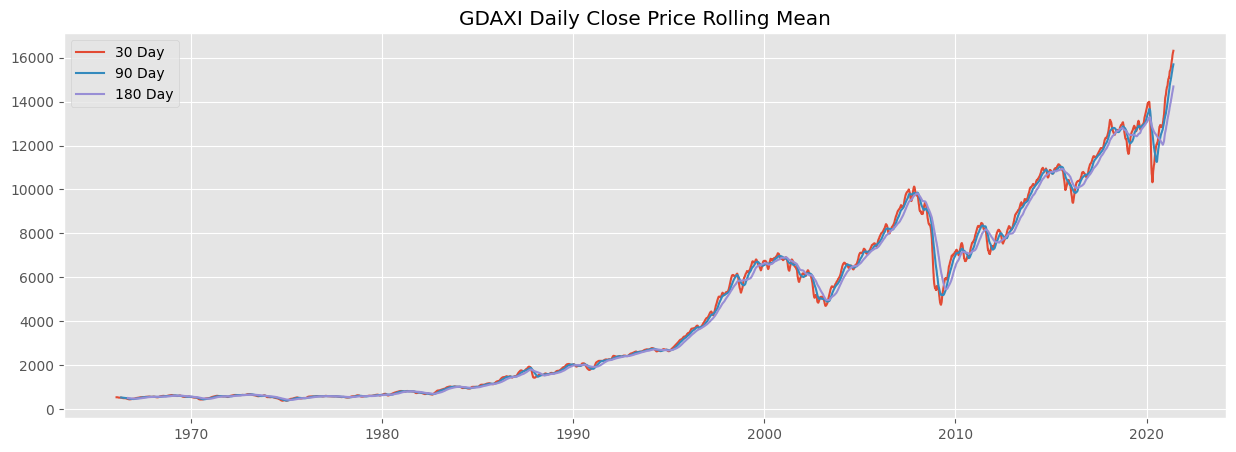

In [19]:
plt.plot(nya['Close'].rolling(30).mean() , label='30 Day')
plt.plot(nya['Close'].rolling(90).mean() , label='90 Day')
plt.plot(nya['Close'].rolling(180).mean() , label='180 Day')
plt.title('GDAXI Daily Close Price Rolling Mean')
plt.legend()

In [20]:
test_size = len(nya[nya.index > '2019-01-01'])
test_size

607

There are 608 Days After 2019



In [21]:
close_train = nya[['Close']][ : -test_size]
close_test = nya[['Close']][-test_size : ]

Text(0.5, 1.0, 'NYA Daily Close Price After 2019')

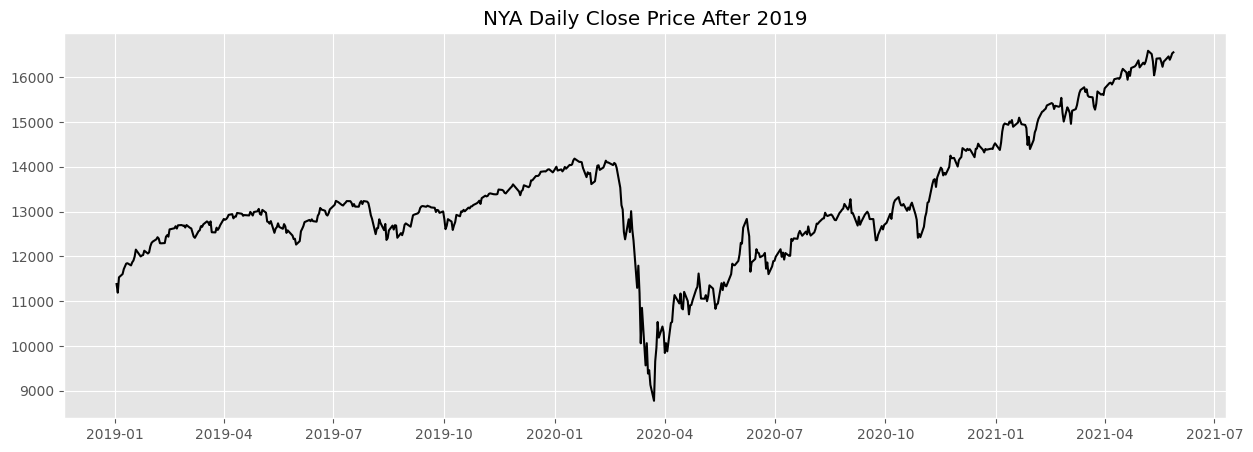

In [22]:
plt.plot(close_test , color='black')
plt.title('NYA Daily Close Price After 2019')

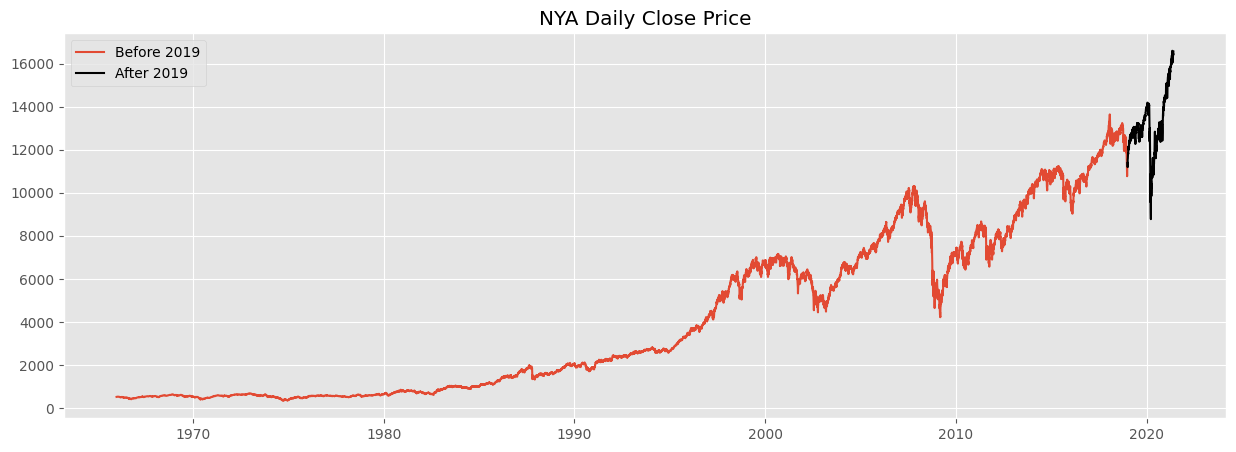

In [23]:
plt.plot(close_train , label='Before 2019')
plt.plot(close_test , color='black' , label='After 2019')
plt.title('NYA Daily Close Price')
plt.legend()

In [24]:
scaler = StandardScaler()

In [25]:
data_train = scaler.fit_transform(close_train.values)
data_test = scaler.transform(close_test.values)

Data Preparation



In [26]:
print('Train shape :',data_train.shape)
print('Test shape :',data_test.shape)

Train shape : (13340, 1)
Test shape : (607, 1)


In [27]:
n_steps = 30

In [28]:
gen_train = TimeseriesGenerator(data_train, data_train, length=n_steps)
gen_test = TimeseriesGenerator(data_test, data_test, length=n_steps)

Input Data Generation for LSTM



In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

model = Sequential()
model.add(Input(shape=(n_steps, 1)))  # Define the input shape
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

In [30]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
model_history = model.fit(gen_train, epochs=50)

Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0036
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0013
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 0.0035
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.0107
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0219
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0024
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0015
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - loss: 7.4106e-04
Epoch 9/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 9.6268e-04
Epoch 10/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 7.9600e-04
Epoch 11/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - loss: 9.2402e-04
Epoch 12/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0011
Epoch 13/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 8.8410e-04
Epoch 14/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0011
Epoch 15/50
104/104 ━━

Text(0.5, 1.0, 'Loss')

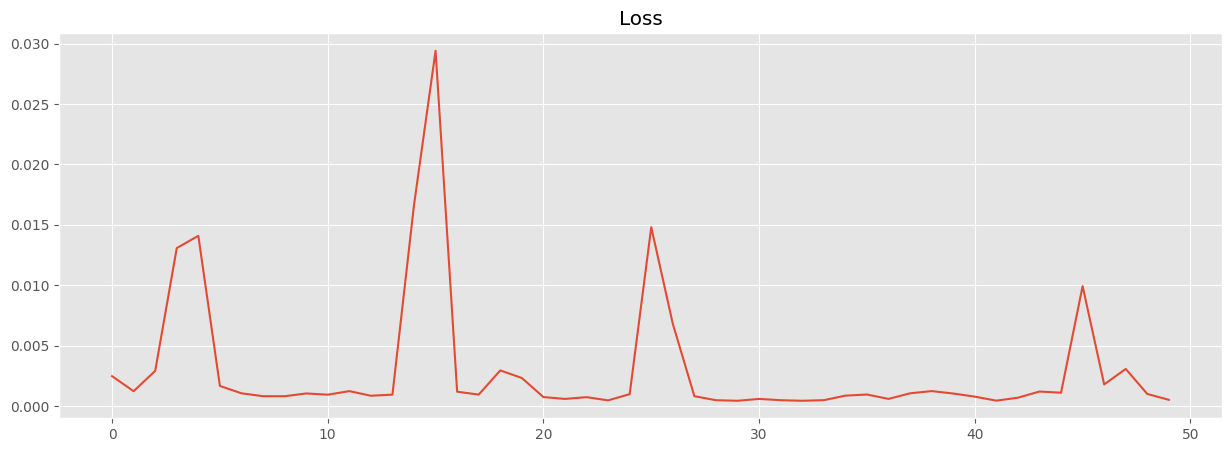

In [35]:
plt.plot(model_history.history['loss'])
plt.title('Loss')

In [36]:
prediction = model.predict(gen_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step


Prediction



In [37]:
index_after_2019 = nya[nya.index > '2019-01-01'].index

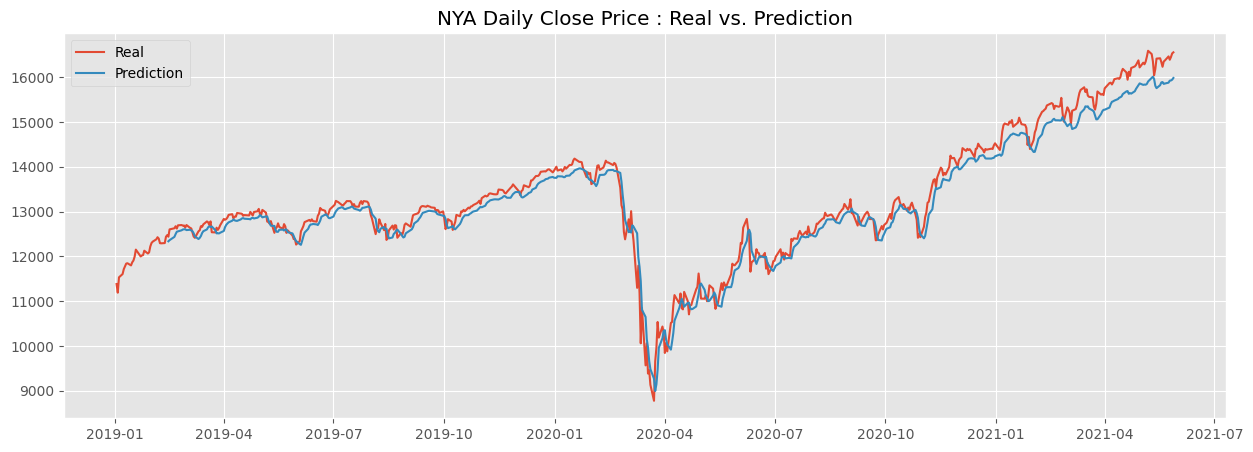

In [38]:
plt.plot(index_after_2019 , scaler.inverse_transform(data_test) , label='Real')
plt.plot(index_after_2019[n_steps : ] , scaler.inverse_transform(prediction) , label='Prediction')
plt.title('NYA Daily Close Price : Real vs. Prediction')
plt.legend()